# Chapter 1: Setup and Imports
This chapter sets up the environment with version-pinned libraries for reproducibility, using a modular setup function for maintainability and scalability across projects.

In [5]:
from importlib.metadata import version
import pkg_resources

def setup_environment():
    !pip install streamlit==1.29.0 -q
    !pip install pyngrok==7.1.0 -q
    !pip install joblib==1.3.2 -q
    import pandas as pd
    import numpy as np
    import warnings; warnings.filterwarnings('ignore')
    import matplotlib.pyplot as plt
    import seaborn as sns
    import streamlit as st
    from imblearn.over_sampling import SMOTE
    from sklearn.preprocessing import MinMaxScaler, LabelEncoder
    from sklearn.model_selection import train_test_split, RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, confusion_matrix, f1_score
    from sklearn.impute import SimpleImputer
    from sklearn.feature_selection import RFE
    import time
    from google.colab import files
    from pyngrok import ngrok
    import joblib
    print(f"Versions: pandas={version('pandas')}, streamlit={version('streamlit')}")
    return True

if setup_environment():
    print("Environment set up successfully!")

Versions: pandas=2.2.2, streamlit=1.29.0
Environment set up successfully!


# Chapter 2: Data Cleaning
This chapter defines a flexible cleaning function for maintainability, saves checkpoints for reproducibility, and ensures data quality appropriate for predicting hospital LOS.

In [6]:
def clean_data(df, impute_strategy='median', outlier_threshold=1.5):
    print("Missing values:\n", df.isnull().sum())
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    binary_cols = ['gender', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum',
                   'substancedependence', 'psychologicaldisordermajor', 'depress',
                   'psychother', 'fibrosisandother', 'malnutrition', 'hemo']
    imputer_numeric = SimpleImputer(strategy=impute_strategy)
    imputer_binary = SimpleImputer(strategy='most_frequent')
    df[numeric_cols] = imputer_numeric.fit_transform(df[numeric_cols])
    df[binary_cols] = imputer_binary.fit_transform(df[binary_cols])
    for col in ['hematocrit', 'neutrophils', 'bmi']:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - outlier_threshold * IQR, Q3 + outlier_threshold * IQR
        df[col] = df[col].clip(lower, upper)
    df.to_csv(f'cleaned_data_{time.ctime()}.csv', index=False)
    print("Data cleaned and checkpoint saved!")
    return df

print("Data cleaning function defined!")

Data cleaning function defined!


# Chapter 3: Exploratory Data Analysis (EDA)
This chapter provides a modular EDA function with saved plots for reproducibility, ensuring appropriate analysis of LOS patterns relevant to hospital planning.

In [19]:
from datetime import datetime

def explore_data(df, feature_to_plot='hematocrit', display=True):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # LOS category distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='los_category')
    plt.title(f"LOS Category Distribution (Raw Data) - {timestamp}")
    if display:
        plt.show()  # Display inline in Colab
    plt.savefig(f"los_distribution_{timestamp}.png")  # Optional save
    plt.close()

    # Feature boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='los_category', y=feature_to_plot)
    plt.title(f"{feature_to_plot} by LOS Category - {timestamp}")
    if display:
        plt.show()  # Display inline in Colab
    plt.savefig(f"{feature_to_plot}_boxplot_{timestamp}.png")  # Optional save
    plt.close()
    print(f"EDA plots generated with timestamp {timestamp}!")

print("EDA function defined!")

EDA function defined!


# Chapter 4: Data Preprocessing and Feature Engineering
This chapter loads data, applies modular cleaning and EDA, engineers features for scalability, and selects features with adjustable RFE for maintainability, saving preprocessed data for reproducibility.

Saving LengthOfStay.csv to LengthOfStay (2).csv
Missing values:
 eid                           0
vdate                         0
rcount                        0
gender                        0
dialysisrenalendstage         0
asthma                        0
irondef                       0
pneum                         0
substancedependence           0
psychologicaldisordermajor    0
depress                       0
psychother                    0
fibrosisandother              0
malnutrition                  0
hemo                          0
hematocrit                    0
neutrophils                   0
sodium                        0
glucose                       0
bloodureanitro                0
creatinine                    0
bmi                           0
pulse                         0
respiration                   0
secondarydiagnosisnonicd9     0
discharged                    0
facid                         0
lengthofstay                  0
dtype: int64
Data cleaned and checkpoin

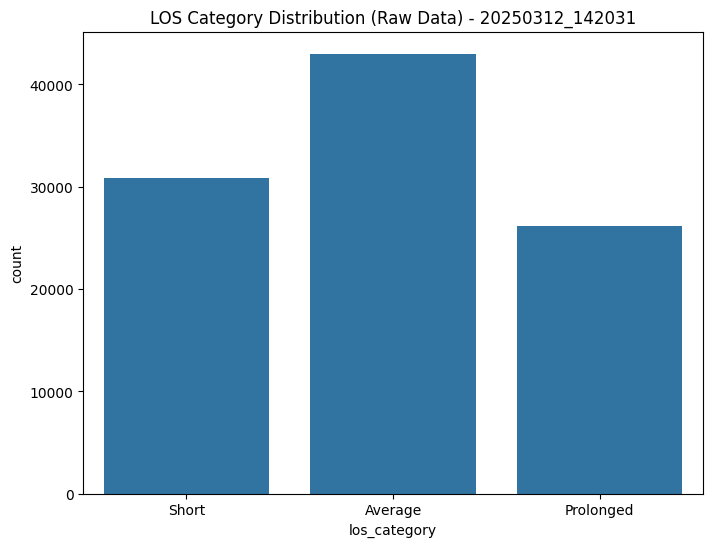

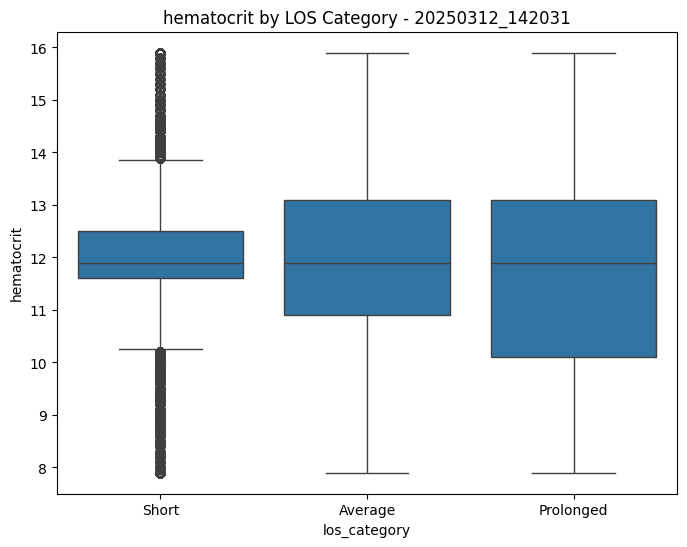

EDA plots generated with timestamp 20250312_142031!
Preprocessing complete, data saved!


In [20]:
# Re-import only necessary libraries for reproducibility and standalone execution
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import time

def engineer_features(df):
    df['lab_severity'] = df['hematocrit'] + df['neutrophils']
    df['comorbidity_score'] = df[['dialysisrenalendstage', 'malnutrition', 'psychologicaldisordermajor']].sum(axis=1)
    return df

def load_and_preprocess_data(clean_func=clean_data, explore_func=explore_data, n_features=15):
    uploaded = files.upload()
    df = pd.read_csv(list(uploaded.keys())[0])
    df = clean_func(df)
    bins = [0, 3, 6, df['lengthofstay'].max() + 1]
    labels = ['Short', 'Average', 'Prolonged']
    df['los_category'] = pd.cut(df['lengthofstay'], bins=bins, labels=labels, right=False)
    explore_func(df, display=True)  # Explicitly set display=True to show plots
    df = engineer_features(df)

    X = df.drop(columns=['lengthofstay', 'los_category', 'eid', 'vdate', 'discharged', 'facid'])
    y = df['los_category']
    binary_cols = ['gender', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum',
                   'substancedependence', 'psychologicaldisordermajor', 'depress',
                   'psychother', 'fibrosisandother', 'malnutrition', 'hemo']
    for col in binary_cols:
        X[col] = X[col].replace({'F': 1, 'M': 0}).astype(int) if col == 'gender' else X[col].astype(int)
    X['rcount'] = X['rcount'].replace('5+', 5).astype(int)

    imputer = SimpleImputer(strategy='median')
    X_numeric = pd.DataFrame(imputer.fit_transform(X.select_dtypes(include=['int64', 'float64'])),
                            columns=X.select_dtypes(include=['int64', 'float64']).columns)
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

    rf = RandomForestClassifier(n_estimators=50, random_state=42)
    selector = RFE(rf, n_features_to_select=n_features, step=1)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    X_selected = selector.fit_transform(X_scaled, y_encoded)
    selected_features = X_scaled.columns[selector.support_]
    X_scaled = pd.DataFrame(X_selected, columns=selected_features)

    X_scaled.to_csv(f'preprocessed_data_{time.ctime()}.csv', index=False)
    np.save('y_encoded.npy', y_encoded)
    print("Preprocessing complete, data saved!")
    return X_scaled, y_encoded, df, le.classes_

# Execute preprocessing
X_scaled, y_encoded, df, class_names = load_and_preprocess_data()

# Chapter 5: Model Training
This chapter trains the model with modular SMOTE and cross-validation for reproducibility, saving the model for maintainability, ensuring robust and appropriate LOS predictions.

In [13]:
# Re-import necessary libraries for reproducibility and standalone execution
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
import time
import joblib
import numpy as np

def train_model(X_train, y_train, smote_strategy='not majority', n_iter=5, cv=5):
    smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    rf = RandomForestClassifier(n_estimators=50, random_state=42)
    param_dist = {
        'n_estimators': [50, 100],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=n_iter, cv=cv,
                                n_jobs=-1, scoring='f1_weighted', random_state=42, verbose=0)
    search.fit(X_train_balanced, y_train_balanced)

    cv_scores = cross_val_score(search.best_estimator_, X_train_balanced, y_train_balanced, cv=cv, scoring='f1_weighted')
    print(f"Cross-validated F1-score: {cv_scores.mean():.3f} (±{cv_scores.std() * 2:.3f})")

    return search.best_estimator_

# Use preprocessed data from Chapter 4
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2,
                                                    random_state=42, stratify=y_encoded)
start_time = time.time()
model = train_model(X_train, y_train)
training_time = time.time() - start_time
y_pred = model.predict(X_test)

joblib.dump(model, f'model_{time.ctime()}.joblib')
with open('model_metadata.txt', 'w') as f:
    f.write(f"Training Time: {training_time:.2f}s\nF1-Score: {f1_score(y_test, y_pred, average='weighted'):.3f}")
print(f"Training complete! Time: {training_time:.2f} seconds")

Cross-validated F1-score: 0.898 (±0.031)
Training complete! Time: 411.30 seconds


# Chapter 6: Streamlit App Creation
This chapter defines a modular app function with version tracking for reproducibility, saving data appropriately for scalable LOS visualization.

In [15]:
def create_app():
    import streamlit as st
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, confusion_matrix, f1_score
    import joblib
    from importlib.metadata import version

    # Load data and model
    X_scaled = pd.read_pickle("X_scaled.pkl")
    y_test = np.load("y_test.npy")
    y_pred = np.load("y_pred.npy")
    df = pd.read_pickle("df.pkl")
    class_names = np.load("class_names.npy", allow_pickle=True)
    training_time = float(open("training_time.txt").read())
    model = joblib.load("model.joblib")

    st.title("Hospital Length of Stay Prediction Dashboard")
    st.write(f"Version: pandas {version('pandas')}, streamlit {version('streamlit')}")
    st.write("This app predicts hospital length of stay using a Random Forest model and visualizes key insights.")

    st.sidebar.header("Options")
    show_data = st.sidebar.checkbox("Show Raw Data", False)
    show_metrics = st.sidebar.checkbox("Show Performance Metrics", True)
    show_features = st.sidebar.checkbox("Show Feature Importance", True)

    if show_data:
        st.subheader("Raw Data Preview")
        st.dataframe(df.head())

    if show_metrics:
        st.subheader("Model Performance")
        f1 = f1_score(y_test, y_pred, average='weighted')
        st.write(f"**F1-Score (Weighted):** {f1:.3f}")
        st.write(f"**Training Time:** {training_time:.2f} seconds")
        report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
        st.write("**Classification Report:**")
        st.json(report)
        cm = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, ax=ax)
        ax.set_title("Confusion Matrix")
        ax.set_ylabel("True Label")
        ax.set_xlabel("Predicted Label")
        st.pyplot(fig)

    if show_features:
        st.subheader("Feature Importance")
        feature_importance = pd.DataFrame({
            'feature': X_scaled.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(10), ax=ax)
        ax.set_title("Top 10 Feature Importance")
        st.pyplot(fig)

    st.subheader("Target Distribution")
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ["#231F20", "#7CAED1", "#ABABAB"]
    sns.countplot(data=df, x="los_category", palette=colors, ax=ax)
    ax.set_title("Distribution of Length of Stay Categories")
    st.pyplot(fig)

# Write the function as a string to app.py
app_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import joblib
from importlib.metadata import version

# Load data and model
X_scaled = pd.read_pickle("X_scaled.pkl")
y_test = np.load("y_test.npy")
y_pred = np.load("y_pred.npy")
df = pd.read_pickle("df.pkl")
class_names = np.load("class_names.npy", allow_pickle=True)
training_time = float(open("training_time.txt").read())
model = joblib.load("model.joblib")

st.title("Hospital Length of Stay Prediction Dashboard")
st.write(f"Version: pandas {version('pandas')}, streamlit {version('streamlit')}")
st.write("This app predicts hospital length of stay using a Random Forest model and visualizes key insights.")

st.sidebar.header("Options")
show_data = st.sidebar.checkbox("Show Raw Data", False)
show_metrics = st.sidebar.checkbox("Show Performance Metrics", True)
show_features = st.sidebar.checkbox("Show Feature Importance", True)

if show_data:
    st.subheader("Raw Data Preview")
    st.dataframe(df.head())

if show_metrics:
    st.subheader("Model Performance")
    f1 = f1_score(y_test, y_pred, average='weighted')
    st.write(f"**F1-Score (Weighted):** {f1:.3f}")
    st.write(f"**Training Time:** {training_time:.2f} seconds")
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    st.write("**Classification Report:**")
    st.json(report)
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title("Confusion Matrix")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    st.pyplot(fig)

if show_features:
    st.subheader("Feature Importance")
    feature_importance = pd.DataFrame({
        'feature': X_scaled.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10), ax=ax)
    ax.set_title("Top 10 Feature Importance")
    st.pyplot(fig)

st.subheader("Target Distribution")
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["#231F20", "#7CAED1", "#ABABAB"]
sns.countplot(data=df, x="los_category", palette=colors, ax=ax)
ax.set_title("Distribution of Length of Stay Categories")
st.pyplot(fig)
'''

with open('app.py', 'w') as f:
    f.write(app_code)
X_scaled.to_pickle("X_scaled.pkl")
np.save("y_test.npy", y_test)
np.save("y_pred.npy", y_pred)
df.to_pickle("df.pkl")
np.save("class_names.npy", class_names)
with open("training_time.txt", "w") as f:
    f.write(str(training_time))
joblib.dump(model, "model.joblib")
print("Streamlit app and data saved!")

Streamlit app and data saved!


# Chapter 7: Running the Streamlit App
This chapter deploys the app with a modular function, logs sessions for reproducibility, and ensures scalability for cloud-based NHS access.

In [17]:
from pyngrok import ngrok
def run_streamlit_app(token):
    ngrok.kill()
    ngrok.set_auth_token(token)
    public_url = ngrok.connect(8501)
    with open('ngrok_session.log', 'a') as f:
        f.write(f"URL: {public_url} at {time.ctime()}\n")
    print(f"Streamlit app running at: {public_url}")
    !streamlit run app.py &>/dev/null &

run_streamlit_app("2uAcGyggvUoQOhjY8fJVmL2Nvfg_7yjDn8KW2Vcm8wPmPVsLu")

Streamlit app running at: NgrokTunnel: "https://c5c9-34-58-28-66.ngrok-free.app" -> "http://localhost:8501"
